# **Introduction**

This project analyzes wearable device data collected from multiple users, including daily activity, step counts, and  sleep stages. The goal is to understand patterns in physical activity and sleep behavior, investigate correlations between activity levels, sleep quality, and calories burned, and determine whether these patterns vary by day of the week.

**Project Objective:**

• Explore user activity and sleep data to identify daily and weekly trends.

• Quantify average activity levels and sleep durations across days of the week.

• Analyze trends in physical activity (steps, calories) at daily and hourly levels.

• Analyze how often users meet the recommended 10,000-step daily activity threshold.

• Identify correlations between steps taken, calories burned, and sleep behavior.

• Examine relationships between physical activity, sleep stages, total steps, and calories burned.

• Test for statistically significant differences in sleep and activity metrics between weekdays and weekends.



In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency, ttest_ind, f_oneway
import re
import matplotlib.ticker as mtick

In [53]:
df_activity = pd.read_csv(r'/content/dailyActivity_merged.csv')
df_steps = pd.read_csv(r'/content/hourlySteps_merged.csv')
df_sleep = pd.read_csv(r'/content/minuteSleep_merged.csv')

# **Data Cleaning**

In [174]:
df_activity.head(5)

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,Total_Active_Mins,Total_Mins,Day_of_week,Missing_Mins,date_only
0,1503960366,2016-03-25,11004,7.11,7.11,0.0,2.57,0.46,4.07,0.0,33,12,205,804,1819,250,1054,Friday,386,2016-03-25
1,1503960366,2016-03-26,17609,11.55,11.55,0.0,6.92,0.73,3.91,0.0,89,17,274,588,2154,380,968,Saturday,472,2016-03-26
2,1503960366,2016-03-27,12736,8.53,8.53,0.0,4.66,0.16,3.71,0.0,56,5,268,605,1944,329,934,Sunday,506,2016-03-27
3,1503960366,2016-03-28,13231,8.93,8.93,0.0,3.19,0.79,4.95,0.0,39,20,224,1080,1932,283,1363,Monday,77,2016-03-28
4,1503960366,2016-03-29,12041,7.85,7.85,0.0,2.16,1.09,4.61,0.0,28,28,243,763,1886,299,1062,Tuesday,378,2016-03-29


In [175]:
df_activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457 entries, 0 to 456
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Id                        457 non-null    int64         
 1   ActivityDate              457 non-null    datetime64[ns]
 2   TotalSteps                457 non-null    int64         
 3   TotalDistance             457 non-null    float64       
 4   TrackerDistance           457 non-null    float64       
 5   LoggedActivitiesDistance  457 non-null    float64       
 6   VeryActiveDistance        457 non-null    float64       
 7   ModeratelyActiveDistance  457 non-null    float64       
 8   LightActiveDistance       457 non-null    float64       
 9   SedentaryActiveDistance   457 non-null    float64       
 10  VeryActiveMinutes         457 non-null    int64         
 11  FairlyActiveMinutes       457 non-null    int64         
 12  LightlyActiveMinutes  

In [176]:
df_steps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24084 entries, 0 to 24083
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Id            24084 non-null  int64         
 1   ActivityHour  24084 non-null  datetime64[ns]
 2   StepTotal     24084 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 564.6 KB


In [177]:
df_sleep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198034 entries, 0 to 198558
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Id           198034 non-null  int64         
 1   date         198034 non-null  datetime64[ns]
 2   value        198034 non-null  int64         
 3   logId        198034 non-null  int64         
 4   sleep_hours  198034 non-null  float64       
 5   date_only    198034 non-null  object        
 6   sleep_stage  198034 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 12.1+ MB


In [178]:
# Changing the date from object to datetime datatype.
df_activity["ActivityDate"]=pd.to_datetime(df_activity["ActivityDate"])
df_steps['ActivityHour'] = pd.to_datetime(df_steps['ActivityHour'], format='%m/%d/%Y %I:%M:%S %p')
df_sleep['date'] = pd.to_datetime(df_sleep['date'])

In [179]:
# Adding all datasets to a dictionary
datasets = {"df_activity": df_activity, "df_steps": df_steps, "df_sleep": df_sleep}

def clean_check():
    for name, df in datasets.items():
        print("Number of null values in the dataset", name, df.isna().sum().sum())
        print("Number of duplicated values in the dataset", name, df.duplicated().sum())
        print ("-------------------------------------------------------")

clean_check()

Number of null values in the dataset df_activity 0
Number of duplicated values in the dataset df_activity 0
-------------------------------------------------------
Number of null values in the dataset df_steps 0
Number of duplicated values in the dataset df_steps 0
-------------------------------------------------------
Number of null values in the dataset df_sleep 0
Number of duplicated values in the dataset df_sleep 0
-------------------------------------------------------


In [180]:
df_sleep.drop_duplicates(inplace=True)

# **Data Exploration and Analysis**

In [181]:
print(f"{df_activity['Id'].nunique()} unique users are present in the daily activity dataset.")
print(f"{df_steps['Id'].nunique()} unique users are present in the hourly steps dataset.")
print(f"{df_sleep['Id'].nunique()} unique users are present in the sleep dataset.")

35 unique users are present in the daily activity dataset.
34 unique users are present in the hourly steps dataset.
23 unique users are present in the sleep dataset.


In [182]:
# Daily Activity - Creating a new column that sums all types of active minutes
df_activity["Total_Active_Mins"] = df_activity['VeryActiveMinutes'] + df_activity['FairlyActiveMinutes'] + df_activity['LightlyActiveMinutes']

# Total minutes in a day = active minutes + sedentary minutes
df_activity["Total_Mins"] = df_activity["Total_Active_Mins"] + df_activity["SedentaryMinutes"]
df_activity["Day_of_week"] = df_activity["ActivityDate"].dt.day_name()

df_activity.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,Total_Active_Mins,Total_Mins,Day_of_week,Missing_Mins,date_only
0,1503960366,2016-03-25,11004,7.11,7.11,0.0,2.57,0.46,4.07,0.0,33,12,205,804,1819,250,1054,Friday,386,2016-03-25
1,1503960366,2016-03-26,17609,11.55,11.55,0.0,6.92,0.73,3.91,0.0,89,17,274,588,2154,380,968,Saturday,472,2016-03-26
2,1503960366,2016-03-27,12736,8.53,8.53,0.0,4.66,0.16,3.71,0.0,56,5,268,605,1944,329,934,Sunday,506,2016-03-27
3,1503960366,2016-03-28,13231,8.93,8.93,0.0,3.19,0.79,4.95,0.0,39,20,224,1080,1932,283,1363,Monday,77,2016-03-28
4,1503960366,2016-03-29,12041,7.85,7.85,0.0,2.16,1.09,4.61,0.0,28,28,243,763,1886,299,1062,Tuesday,378,2016-03-29


In [183]:
# Checking for data consistency with respect to total minutes in a day
under_24hrs = len(df_activity[df_activity['Total_Mins'] < 1440])
over_24hrs = len(df_activity[df_activity['Total_Mins'] > 1440])
exactly_24hrs = len(df_activity[df_activity['Total_Mins'] == 1440])

print(f"{under_24hrs} entries have less than 1440 total minutes (i.e., less than 24 hours).")
print(f"{over_24hrs} entries have more than 1440 total minutes (i.e., over 24 hours).")
print(f"{exactly_24hrs} entries have exactly 1440 total minutes, indicating valid 24-hour data.")

224 entries have less than 1440 total minutes (i.e., less than 24 hours).
0 entries have more than 1440 total minutes (i.e., over 24 hours).
233 entries have exactly 1440 total minutes, indicating valid 24-hour data.


In [184]:
# Creating column "Missing_Mins" calculates the total mins minus 1440 (minutes in 24hrs)
df_activity["Missing_Mins"] = (1440 - df_activity["Total_Mins"])

missing_mins = df_activity[df_activity["Missing_Mins"] != 0]["Missing_Mins"]
extra_mins_count = df_activity[df_activity["Missing_Mins"] < 0].shape[0]

def missing_mins_summary():
    print("Average missing minutes per day:", round(missing_mins.mean(), 2))
    print("Average missing hours per day:", round(missing_mins.mean() / 60, 2))
    print("Average percentage of untracked time per day:", round((missing_mins.mean() / 1440) * 100, 2), "%")
    print("Total rows with missing or extra minutes:", missing_mins.shape[0])
    print("Rows with more than 1440 minutes (data error):", extra_mins_count)

missing_mins_summary()

Average missing minutes per day: 499.75
Average missing hours per day: 8.33
Average percentage of untracked time per day: 34.7 %
Total rows with missing or extra minutes: 224
Rows with more than 1440 minutes (data error): 0


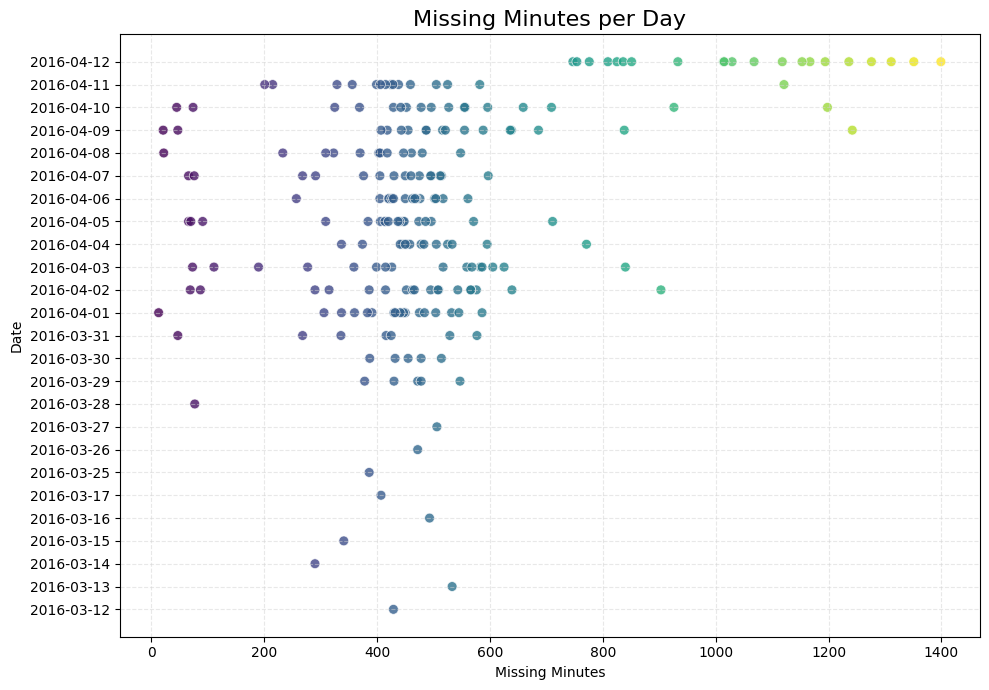

In [261]:
# Filter only rows with missing minutes
filtered_data = df_activity[df_activity['Missing_Mins'] != 0].copy()
filtered_data['ActivityDate'] = pd.to_datetime(filtered_data['ActivityDate'])
filtered_data['ActivityDateStr'] = filtered_data['ActivityDate'].dt.strftime('%Y-%m-%d')
filtered_data = filtered_data.sort_values('ActivityDate')

plt.figure(figsize=(10, 7))
sc= sns.scatterplot(data=filtered_data,x='Missing_Mins',y='ActivityDateStr',hue='Missing_Mins',palette='viridis',legend=False,alpha=0.8, s=50)
plt.title('Missing Minutes per Day', fontsize=16)
plt.xlabel('Missing Minutes')
plt.ylabel('Date')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.grid(linestyle='--',color='lightgray',alpha=0.5)
plt.show()

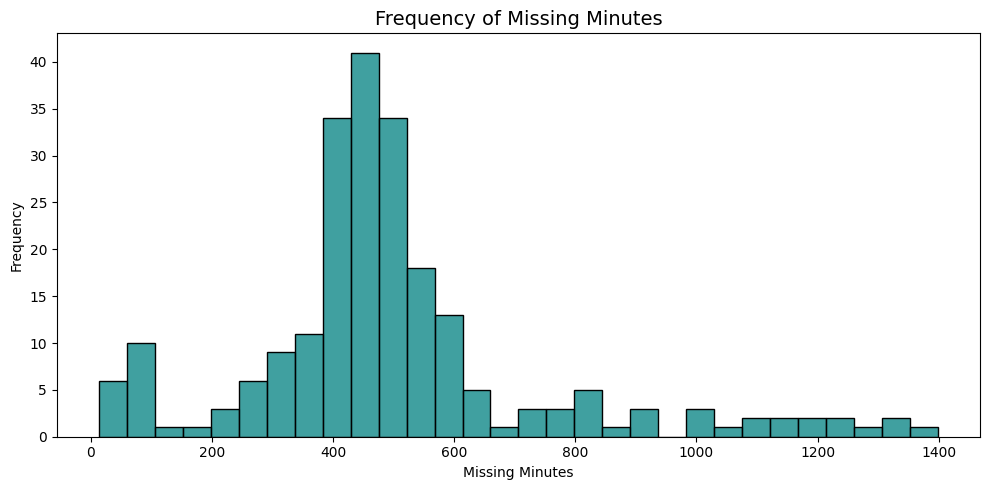

In [264]:
# Distribution of Missing minutes
plt.figure(figsize=(10, 5))
ax = sns.histplot(data=filtered_data, x='Missing_Mins', bins=30, color='teal')
plt.title('Frequency of Missing Minutes', fontsize=14)
plt.xlabel('Missing Minutes')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

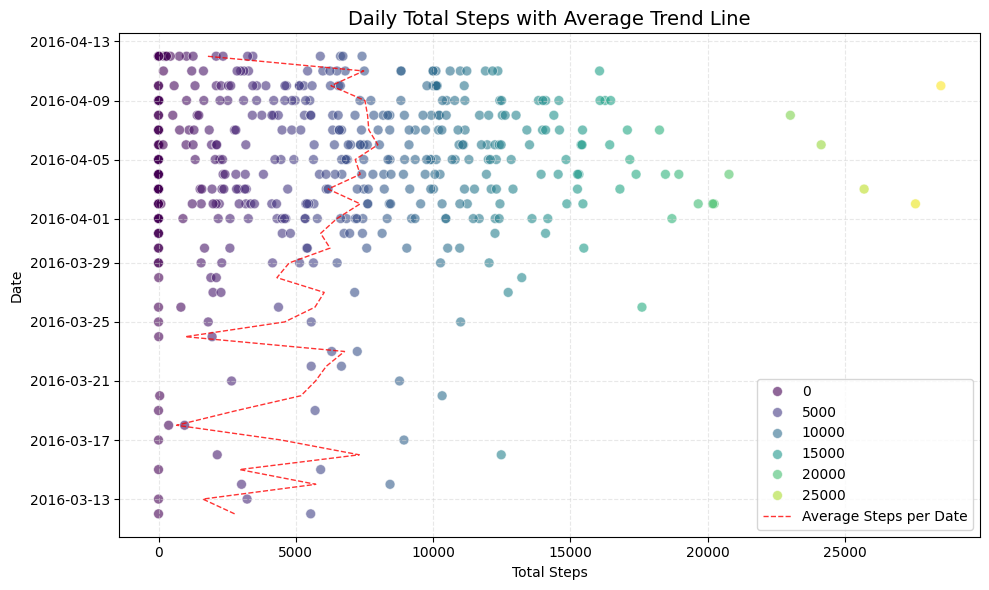

In [266]:
# Calculating average steps per date
avg_steps_per_date = df_activity.groupby('ActivityDate')['TotalSteps'].mean()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_activity['TotalSteps'], y=df_activity['ActivityDate'], palette='viridis', hue=df_activity['TotalSteps'], legend='brief', alpha=0.6, s=50)
plt.plot(avg_steps_per_date.values, avg_steps_per_date.index, color='red', linestyle='--', linewidth=1, alpha=0.8, label='Average Steps per Date')
plt.title('Daily Total Steps with Average Trend Line', fontsize=14)
plt.xlabel('Total Steps')
plt.ylabel('Date')
plt.tight_layout()
plt.grid(linestyle='--', color='lightgray', alpha=0.5)
plt.legend()
plt.show()

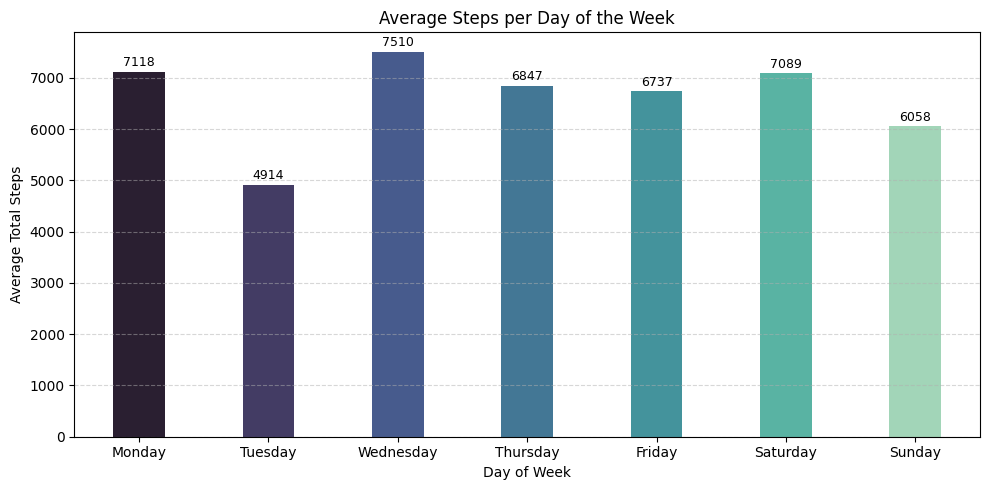

In [270]:
# Calculating the average of total steps per day
average_steps_per_day = df_activity.groupby("Day_of_week", observed=True)["TotalSteps"].mean().round(1)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_steps_per_day = average_steps_per_day.reindex(days_order)

plt.figure(figsize=(10, 5))
ax = sns.barplot(x=average_steps_per_day.index, y=average_steps_per_day.values, palette= 'mako',hue=average_steps_per_day.index, width=0.4)
plt.title('Average Steps per Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Total Steps')
for i, value in enumerate(average_steps_per_day.values):
    ax.text(i, value + 50, f'{int(value)}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

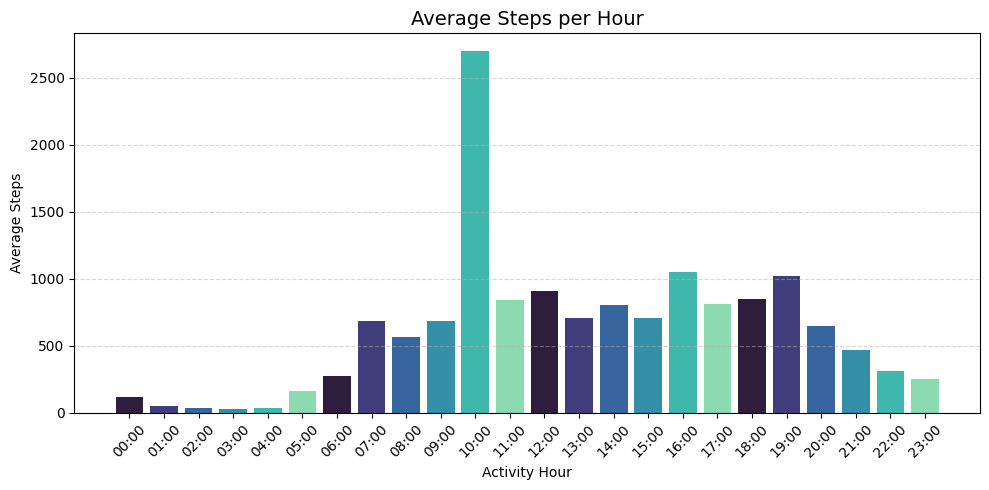

In [271]:
# Calculating Average Steps per hour
average_steps_per_hour = df_steps.groupby('ActivityHour')['StepTotal'].mean().sort_index()
hours_str = [hour.strftime('%H:%M') for hour in average_steps_per_hour.index]
colors = sns.color_palette("mako")

plt.figure(figsize=(10,5))
bars = plt.bar(hours_str, average_steps_per_hour.values.round(0),color=colors)
plt.title('Average Steps per Hour', fontsize=14)
plt.xlabel('Activity Hour')
plt.ylabel('Average Steps')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

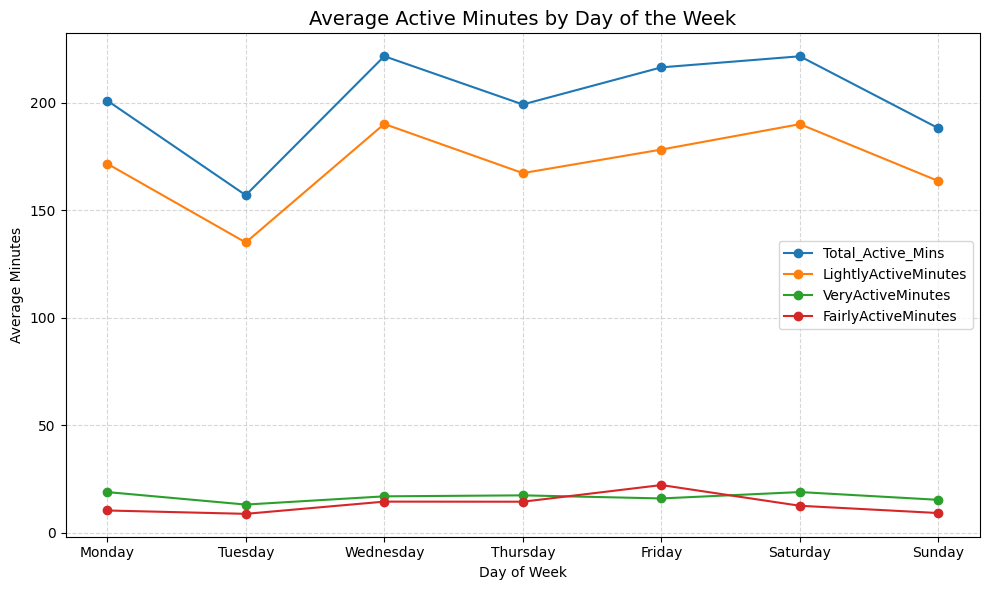

In [191]:
# Calculating average active minutes by day of the week
average_active_day = df_activity.groupby('Day_of_week', observed=False)[['Total_Active_Mins', 'LightlyActiveMinutes', 'VeryActiveMinutes', 'FairlyActiveMinutes']].mean().round(2)
average_active_day = average_active_day.reindex(days_order)

plt.figure(figsize=(10, 6))
for col in average_active_day.columns:
    plt.plot(average_active_day.index, average_active_day[col], marker='o', label=col)
plt.title('Average Active Minutes by Day of the Week', fontsize=14)
plt.xlabel('Day of Week')
plt.ylabel('Average Minutes')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [192]:
# Calculating average active minutes per day across entire dataset
avg_mins = df_activity["Total_Active_Mins"].mean()
print(f"Average active minutes per day: {avg_mins:.2f} mins ({avg_mins/60:.2f} hrs)")

Average active minutes per day: 199.76 mins (3.33 hrs)


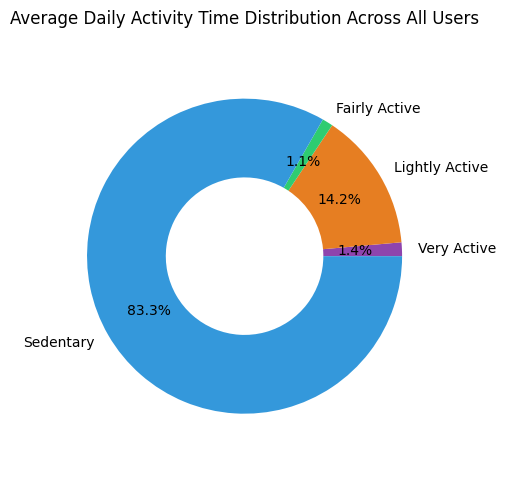

In [298]:
# Calculating average minutes for each activity level
avg_veryactive = round(df_activity['VeryActiveMinutes'].mean() / 60, 2)
avg_fairlyactive = round(df_activity['FairlyActiveMinutes'].mean() / 60, 2)
avg_lightlyactive = round(df_activity['LightlyActiveMinutes'].mean() / 60, 2)
avg_sedentary = round(df_activity['SedentaryMinutes'].mean() / 60, 2)

avg_activity_minutes = pd.Series({'Very Active': avg_veryactive,'Lightly Active': avg_lightlyactive,
                                  'Fairly Active': avg_fairlyactive,'Sedentary': avg_sedentary})
colors = ['#8e44ad', '#e67e22', '#2ecc71',  '#3498db']

plt.figure(figsize=(5, 5))
plt.pie(avg_activity_minutes.values, labels=avg_activity_minutes.index,
        autopct='%1.1f%%', startangle=0, colors=colors, wedgeprops={'width': 0.5},pctdistance=0.7 )
plt.title('Average Daily Activity Time Distribution Across All Users')
plt.axis('equal')
plt.tight_layout()
plt.show()

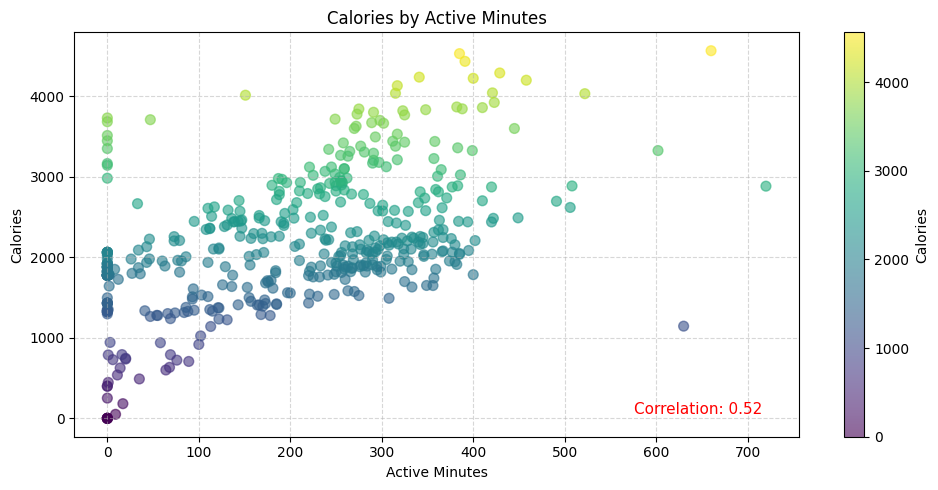

In [195]:
# Calculating correlation coefficient for TotalSteps and Calories
correlation = np.corrcoef(df_activity['Total_Active_Mins'], df_activity['Calories'])[0, 1]

plt.figure(figsize=(10, 5))
scatter = plt.scatter(df_activity['Total_Active_Mins'], df_activity['Calories'], c=df_activity['Calories'],  cmap='viridis',  alpha=0.6, s=50)
cbar = plt.colorbar(scatter)
cbar.set_label('Calories')
plt.title('Calories by Active Minutes')
plt.xlabel('Active Minutes')
plt.ylabel('Calories')
plt.text(0.95, 0.05, f'Correlation: {correlation:.2f}',ha='right', va='bottom', transform=plt.gca().transAxes,fontsize=11,color='red')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

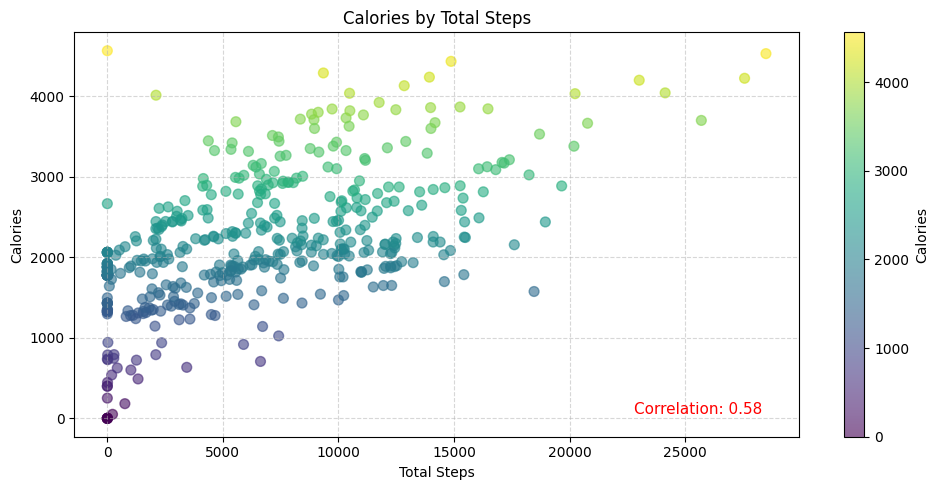

In [138]:
# Calculating correlation coefficient for TotalSteps and Calories
correlation = np.corrcoef(df_activity['TotalSteps'], df_activity['Calories'])[0, 1]

plt.figure(figsize=(10, 5))
scatter = plt.scatter(df_activity['TotalSteps'], df_activity['Calories'], c=df_activity['Calories'],  cmap='viridis',alpha=0.6, s=50)
cbar = plt.colorbar(scatter)
cbar.set_label('Calories')
plt.title('Calories by Total Steps')
plt.xlabel('Total Steps')
plt.ylabel('Calories')
plt.text(0.95, 0.05, f'Correlation: {correlation:.2f}',ha='right', va='bottom', transform=plt.gca().transAxes,fontsize=11,color='red')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


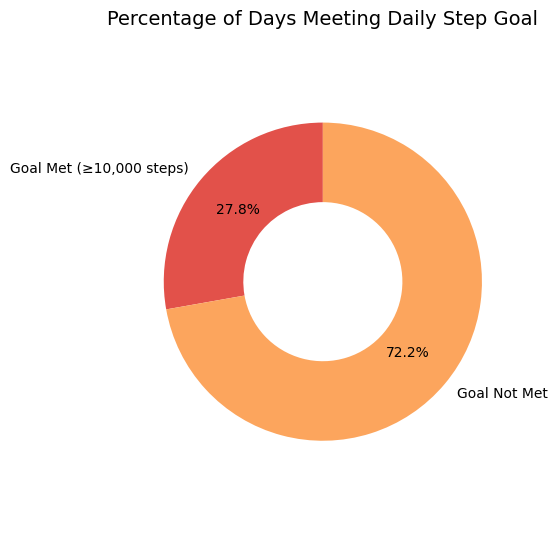

In [299]:
# Proportion of days where users met the recommended daily step goal of 10,000 steps
step_goal = 10000
met_goal = (df_activity['TotalSteps'] >= step_goal).sum()
not_met = len(df_activity) - met_goal
labels = ['Goal Met (≥10,000 steps)', 'Goal Not Met']

plt.figure(figsize=(5.5, 5.5))
plt.pie([met_goal, not_met], labels=labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Spectral'), wedgeprops={'width': 0.5},pctdistance=0.7)
plt.title('Percentage of Days Meeting Daily Step Goal', fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [197]:
# Sleep data
df_sleep['date_only'] = df_sleep['date'].dt.date
sleep_stage_map = {1: 'Asleep', 2: 'Restless', 3: 'Awake'}
df_sleep['sleep_stage'] = df_sleep['value'].map(sleep_stage_map)

# Calculating minutes per sleep stage for a user per day
sleep_summary = df_sleep.groupby(['Id', 'date_only', 'sleep_stage']).size().unstack(fill_value=0)

# Calculating total sleep minutes (considering Asleep + Restless as sleep time)
sleep_summary['Total_Sleep_Minutes'] = sleep_summary.get('Asleep', 0) + sleep_summary.get('Restless', 0)
sleep_summary['Total_Sleep_Hours'] = sleep_summary['Total_Sleep_Minutes'] / 60

sleep_summary = sleep_summary.reset_index()
sleep_summary['Day_of_week'] = pd.to_datetime(sleep_summary['date_only']).dt.day_name()

days_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
avg_sleep_by_day = sleep_summary.groupby('Day_of_week')['Total_Sleep_Hours'].mean().reindex(days_order)

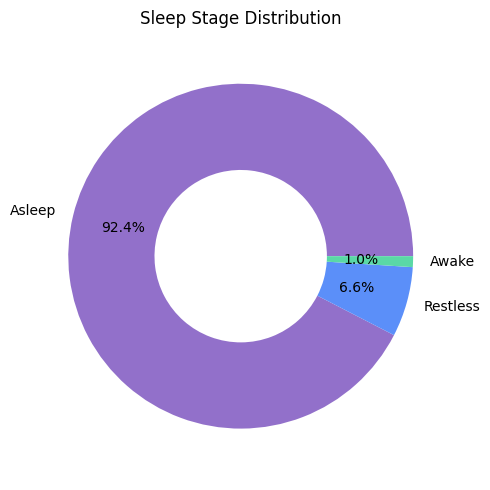

In [250]:
# Overall Sleep Stage Distribution
stage_counts = df_sleep['sleep_stage'].value_counts()
colors = [ '#9270CA','#5B8FF9', '#5AD8A6', '#6DC8EC']

plt.figure(figsize=(5, 5))
plt.pie( stage_counts.values, labels=stage_counts.index, autopct='%1.1f%%', startangle=0, colors=colors, wedgeprops={'width': 0.5},pctdistance=0.7 )
plt.title('Sleep Stage Distribution')
plt.axis('equal')
plt.title('Sleep Stage Distribution')
plt.tight_layout()
plt.show()

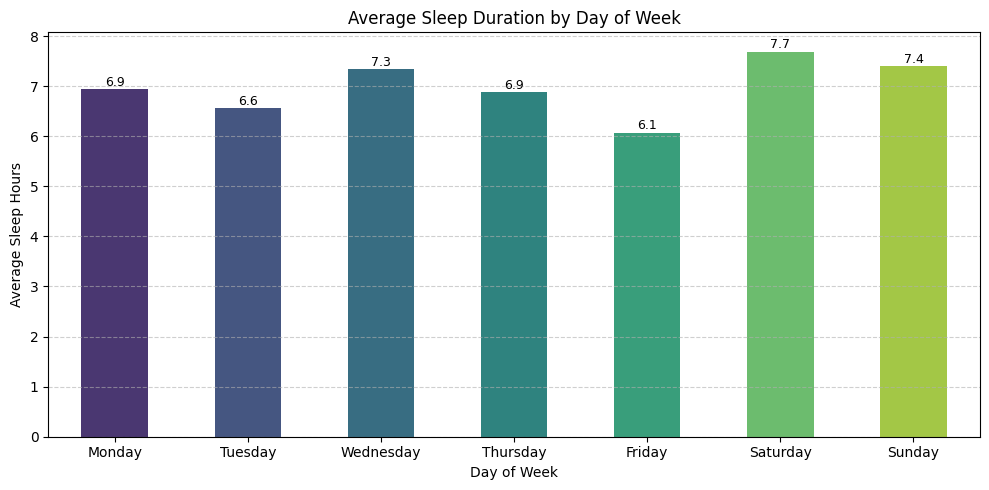

In [282]:
# Calculating Average sleep hours by day of week
plt.figure(figsize=(10,5))
ax = sns.barplot(x=avg_sleep_by_day.index, y=avg_sleep_by_day.values, palette='viridis',width=0.5, hue=avg_sleep_by_day.index)
plt.title('Average Sleep Duration by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Sleep Hours')
for i, value in enumerate(avg_sleep_by_day.values):
    ax.text(i, value+0.01, f'{value:.1f}', ha='center', va='bottom', fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


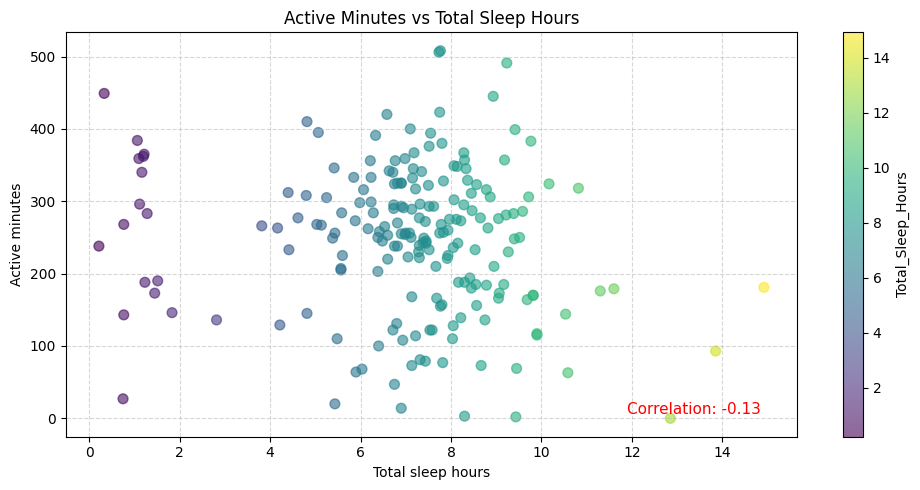

In [199]:
# Merging sleep summary with daily activity to analyze correlation
df_activity['date_only'] = df_activity['ActivityDate'].dt.date

merged_df = pd.merge(sleep_summary, df_activity, left_on=['Id', 'date_only'], right_on=['Id', 'date_only'], how='inner')

# Correlation between total sleep hours and total active minutes
correlation = np.corrcoef(merged_df['Total_Sleep_Hours'], merged_df['Total_Active_Mins'])[0, 1]

plt.figure(figsize=(10, 5))
scatter = plt.scatter(merged_df['Total_Sleep_Hours'], merged_df['Total_Active_Mins'], c=merged_df['Total_Sleep_Hours'],  cmap='viridis',alpha=0.6, s=50)
cbar = plt.colorbar(scatter)
cbar.set_label('Total_Sleep_Hours')
plt.title('Active Minutes vs Total Sleep Hours')
plt.xlabel('Total sleep hours')
plt.ylabel('Active minutes')
plt.text(0.95, 0.05, f'Correlation: {correlation:.2f}',ha='right', va='bottom', transform=plt.gca().transAxes,fontsize=11,color='red')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


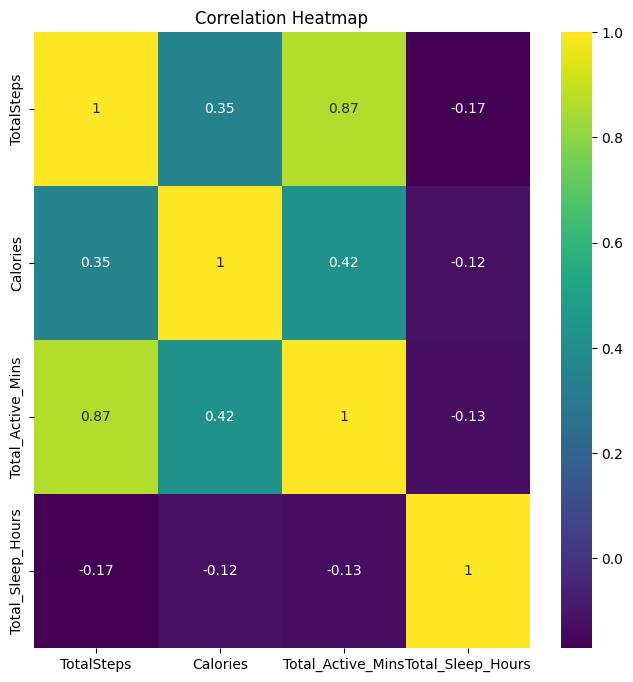

In [260]:
# Correlation Between Steps, Activity, Sleep, and Calories
corr_cols = ['TotalSteps', 'Calories', 'Total_Active_Mins', 'Total_Sleep_Hours']
plt.figure(figsize=(8,8))
sns.heatmap(merged_df[corr_cols].corr(), annot=True, cmap='viridis')
plt.title('Correlation Heatmap')
plt.show()

# **Statistical Tests**

In [226]:
# T-test: Comparison of Average Sleep Hours on Weekdays vs. Weekends
weekend_sleep = merged_df[merged_df['Day_of_week_x'].isin(['Saturday', 'Sunday'])]['Total_Sleep_Hours']
weekday_sleep = merged_df[~merged_df['Day_of_week_x'].isin(['Saturday', 'Sunday'])]['Total_Sleep_Hours']

stat, p_value = ttest_ind(weekday_sleep, weekend_sleep, equal_var=False)

print(f"T-test statistic: {stat:.3f}")
print(f"P-value: {p_value:.3f}\n")

if p_value < 0.05:
    print("Result : The difference in sleep hours between weekdays and weekends is statistically significant.")
else:
    print("Result: No statistically significant difference in sleep hours between weekdays and weekends.")

T-test statistic: -1.426
P-value: 0.157

Result: No statistically significant difference in sleep hours between weekdays and weekends.


**Result Interpretation:**

Since the p-value (0.157) is greater than the common significance level of 0.05, we do not have sufficient evidence to reject the null hypothesis. This means there is no statistically significant difference in the average total sleep hours between weekdays and weekends in this dataset.

In [228]:
# T-test: Comparison of Average Active Minutes on Weekdays vs. Weekends
weekend_active = merged_df[merged_df['Day_of_week_x'].isin(['Saturday', 'Sunday'])]['Total_Active_Mins']
weekday_active = merged_df[~merged_df['Day_of_week_x'].isin(['Saturday', 'Sunday'])]['Total_Active_Mins']

stat, p_value = ttest_ind(weekday_active, weekend_active, equal_var=False)
print(f"T-test statistic: {stat:.3f}")
print(f"P-value: {p_value:.3f}\n")

if p_value < 0.05:
    print("Result: The difference in active minutes between weekdays and weekends is statistically significant.")
else:
    print("Result: No statistically significant difference in active minutes between weekdays and weekends.")

T-test statistic: -0.714
P-value: 0.477

Result: No statistically significant difference in active minutes between weekdays and weekends.


**Result Interpretation:**

Since the p-value (0.477) is much greater than the typical significance level of 0.05, there is insufficient evidence to reject the null hypothesis. This means there is no statistically significant difference in the average total active minutes between weekdays and weekends in this dataset.

In [229]:
# Chi-Square Test: Association Between Sleep Stages and Day of the Week
df_sleep['Day_of_week'] = pd.to_datetime(df_sleep['date_only']).dt.day_name()
contingency_table = pd.crosstab(df_sleep['Day_of_week'], df_sleep['sleep_stage'])

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square statistic: {chi2:.3f}")
print(f"P-value: {p:.3f}")
print(f"Degrees of freedom: {dof}")

if p < 0.05:
    print("Result: The distribution of sleep stages differs significantly by day of the week.")
else:
    print("Result: No significant difference in sleep stage distribution by day of the week.")

Contingency Table:
 sleep_stage  Asleep  Awake  Restless
Day_of_week                         
Friday        21859    219      1456
Monday        28440    228      1933
Saturday      30783    412      2436
Sunday        30643    319      2186
Thursday      22789    227      1549
Tuesday       24386    311      1582
Wednesday     24138    297      1841

Chi-square statistic: 111.637
P-value: 0.000
Degrees of freedom: 12
Result: The distribution of sleep stages differs significantly by day of the week.


**Result Interpretaion:**

Since p-value is less than 0.05, we reject the null hypothesis and conclude that the distribution of sleep stages (Asleep, Restless, Awake) significantly varies across days of the week.

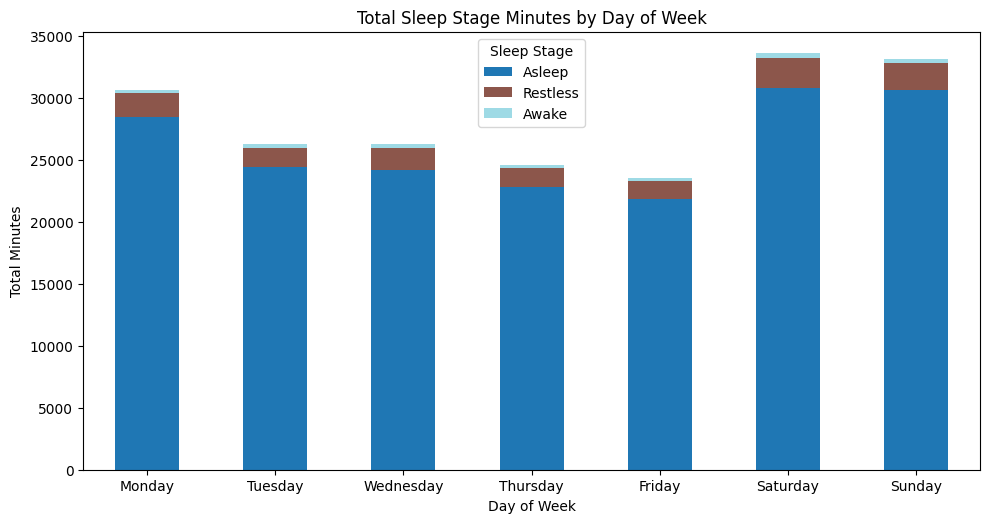

In [301]:
# Visualize the sleep stage distribution by day of the week
# This helps us understand the nature of the significant differences
sleep_stage_by_day = sleep_summary.groupby('Day_of_week')[['Asleep', 'Restless', 'Awake']].sum().reindex(days_order)

sleep_stage_by_day.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
plt.title('Total Sleep Stage Minutes by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Minutes')
plt.legend(title='Sleep Stage')
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()